In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
class BasicCNN(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = (3, 3), stride = (1,1), padding = (1,1))
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(128*7*7, 128)
        self.dense2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, input_tensor):
        op1 = self.pool1(self.relu(self.bn1(self.conv1(input_tensor))))
        op2 = self.pool2(self.relu(self.bn2(self.conv2(op1))))
        flattened = self.flatten(op2)
        linear1 = self.relu(self.dense1(flattened))
        return self.dense2(linear1)

In [8]:
batch_size = 64
learning_rate = 0.01
num_classes = 10
in_channels = 1
num_epochs = 10

In [4]:
train_data = datasets.MNIST(root = "datasets", train = True, download = True, transform = transforms.ToTensor())
test_data = datasets.MNIST(root = "datasets/", train = False, download = True, transform = transforms.ToTensor())
train_loader = DataLoader(dataset = train_data, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(dataset = test_data, shuffle = False, batch_size = batch_size)

print(f"Total Samples in training set: {len(train_loader.dataset)} | Total Batches in training set: {len(train_loader)/batch_size}")
print(f"Total Samples in testing set: {len(test_loader.dataset)} | Total Batches in testing set: {len(test_loader)/batch_size}")

Total Samples in training set: 60000 | Total Batches in training set: 14.65625
Total Samples in testing set: 10000 | Total Batches in testing set: 2.453125


In [6]:
conv_model = BasicCNN(in_channels, num_classes)
print(conv_model)
print()
print(summary(conv_model, input_size = (batch_size, 1, 28, 28)))

BasicCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=6272, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 64, 28, 28]          640
├─BatchNorm2d: 1-2                       [64, 64, 28,

In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_model.parameters(), lr = learning_rate)
print(f"Loss: {loss} | Optimizer: {optimizer}")

Loss: CrossEntropyLoss() | Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [11]:
#Training Loop
losses = []
accuracies = []
loss_accumulation = 0
correct = 0
conv_model.to(device)
conv_model.train()

for epoch in tqdm(range(num_epochs)):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        outputs = conv_model(data)
        loss_batch = loss(outputs, targets)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

        loss_accumulation += loss_batch.item()
        correct += (outputs.argmax(1) == targets).sum().item()
    
    losses.append(loss_accumulation/len(train_loader.dataset))
    accuracies.append(correct / len(train_loader.dataset))        

100%|██████████| 10/10 [02:14<00:00, 13.41s/it]


Text(0, 0.5, 'Loss')

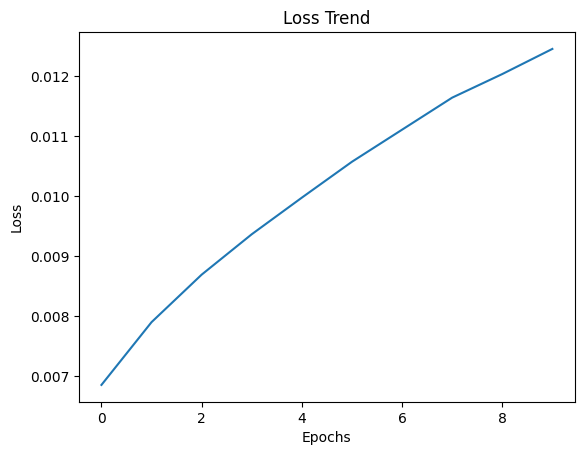

In [12]:
#Plotting Loss
plt.plot(range(num_epochs), losses)
plt.title("Loss Trend")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

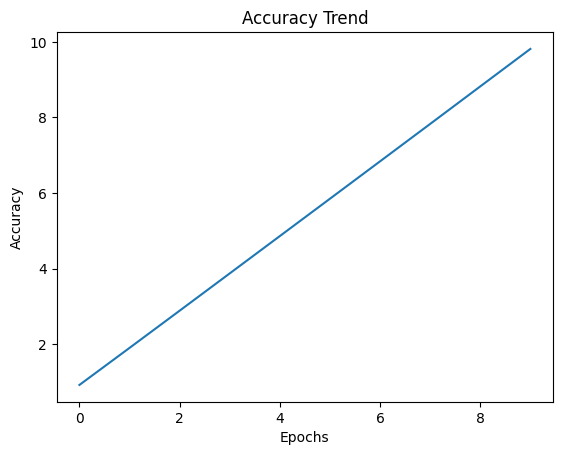

In [13]:
#Plotting Accuracy
plt.plot(range(num_epochs), accuracies)
plt.title("Accuracy Trend")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

In [14]:
#Eval Loop
conv_model.eval()
correct = 0
total_loss = 0

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data, targets = data.to(device), targets.to(device)

        outputs = conv_model(data)
        loss_batch = loss(outputs, targets)
        
        correct += (outputs.argmax(1) == targets).sum().item()
        total_loss += loss_batch.item()
print(f"Accuracy: {correct/len(test_loader.dataset)} | Total Loss: {total_loss/len(test_loader.dataset)}")


Accuracy: 0.9865 | Total Loss: 0.0009266928806481019
